# Домашнее задание №1. Извлечение признаков изображения, поиск по картинкам

Распознавание рукописного ввода на примере базы MNIST

Построить классификатор изображений рукописного ввода на базе MNIST. В качестве шаблона в данной работе можно использовать ipython-ноутбук 002-digit.ipynb.

Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей.

Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста Digit Recognizer на Kaggle.

Решение необходимо предоставить в виде ipython-ноутбука с реализацией процесса построения модели и скриншота с финальным результатом на Kaggle.

## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

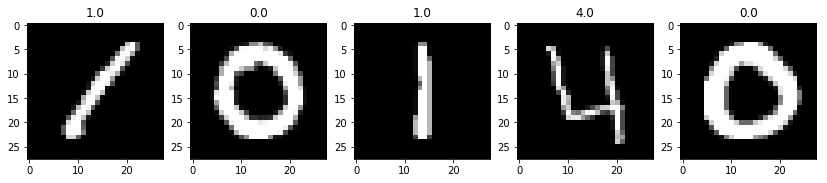

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

# Часть №1.

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [6]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [7]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [8]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [9]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

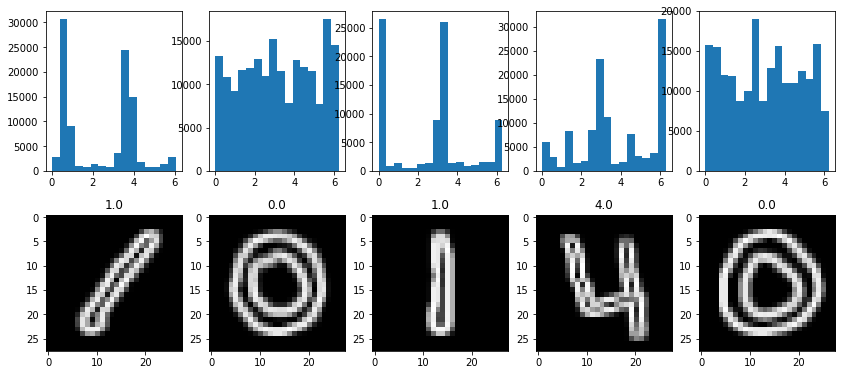

In [10]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [11]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [12]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [13]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [14]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [15]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

# 1. Для начала будем использовать KNN классификатор.

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [17]:
params = {
    'n_neighbors':np.arange(1, 10)
}

gsearch = GridSearchCV(KNeighborsClassifier(), params, n_jobs=-1)
gsearch.fit(x_train, y_train)
n_neighbors_best = gsearch.best_params_['n_neighbors']

In [18]:
clf = KNeighborsClassifier(n_neighbors=n_neighbors_best)
clf.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=9, p=2,
           weights='uniform')

In [19]:
y_val_predict = clf.predict(x_val)

In [20]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, y_val_predict))

Accuracy: 0.6030952380952381


In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_predict))

              precision    recall  f1-score   support

         0.0       0.33      0.49      0.40       816
         1.0       0.95      0.95      0.95       909
         2.0       0.44      0.38      0.40       846
         3.0       0.62      0.68      0.65       937
         4.0       0.68      0.68      0.68       839
         5.0       0.62      0.60      0.61       702
         6.0       0.42      0.38      0.40       785
         7.0       0.86      0.72      0.78       893
         8.0       0.51      0.46      0.48       835
         9.0       0.67      0.64      0.65       838

   micro avg       0.60      0.60      0.60      8400
   macro avg       0.61      0.60      0.60      8400
weighted avg       0.61      0.60      0.61      8400



In [22]:
pred_test = clf.predict(test_hist).astype(int)

## Визуализируем предсказания

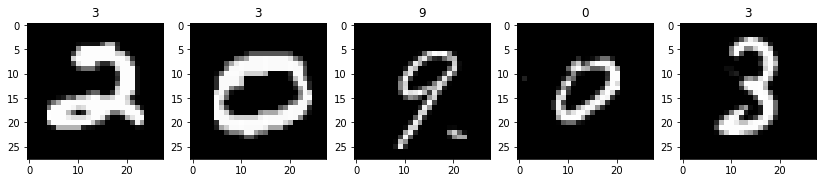

In [23]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [24]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

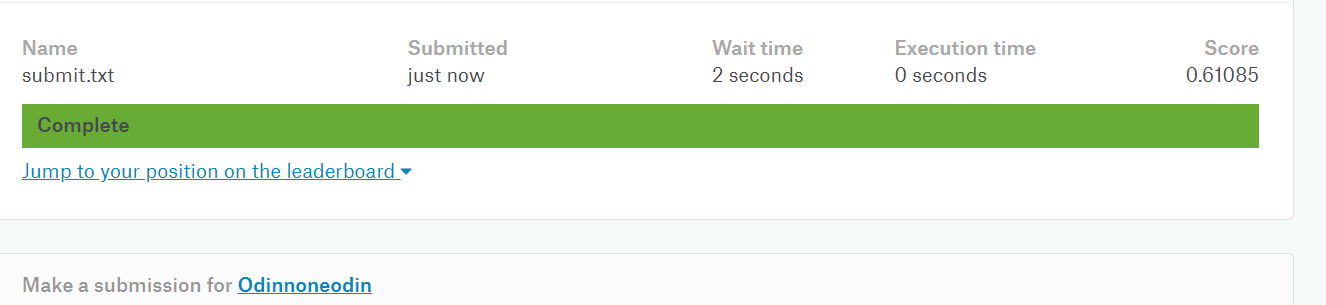
### Your submission scored 0.61

# 2. Теперь попробуем XGB.

In [25]:
from xgboost import XGBClassifier

In [26]:
params = {
    'learning_rate':np.linspace(0.1, 0.9, 9),
    'max_depth':np.arange(1, 5)
}

gsearch = GridSearchCV(XGBClassifier(), params, n_jobs=-1)
gsearch.fit(x_train, y_train)
learning_rate_best = gsearch.best_params_['learning_rate']
max_depth_best = gsearch.best_params_['max_depth']

In [27]:
clf = XGBClassifier(
    max_depth=max_depth_best,
    learning_rate=learning_rate_best
)
clf.fit(x_train, y_train)
y_val_predict = clf.predict(x_val)

In [28]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, y_val_predict))

Accuracy: 0.6579761904761905


In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_predict))

              precision    recall  f1-score   support

         0.0       0.43      0.42      0.43       816
         1.0       0.98      0.97      0.97       909
         2.0       0.53      0.48      0.50       846
         3.0       0.66      0.70      0.68       937
         4.0       0.75      0.72      0.73       839
         5.0       0.63      0.67      0.65       702
         6.0       0.50      0.50      0.50       785
         7.0       0.87      0.80      0.83       893
         8.0       0.51      0.58      0.55       835
         9.0       0.69      0.69      0.69       838

   micro avg       0.66      0.66      0.66      8400
   macro avg       0.65      0.65      0.65      8400
weighted avg       0.66      0.66      0.66      8400



In [30]:
pred_test = clf.predict(test_hist).astype(int)

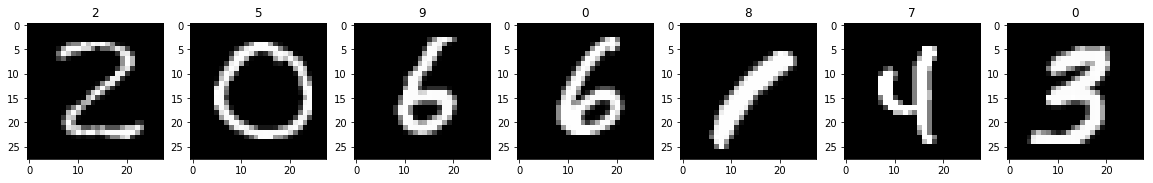

In [31]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

In [32]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

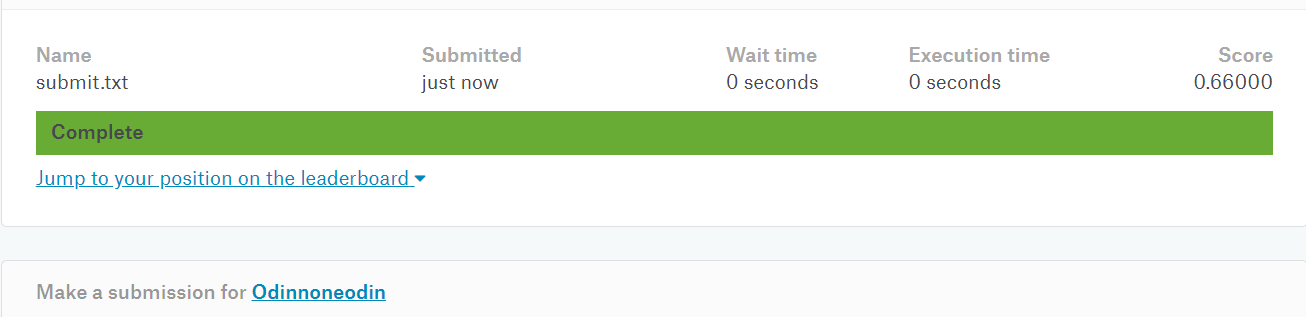
### Your submission scored 0.66

# 3. RandomForestClassifier    

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
params = {
    'max_depth':np.arange(1, 7)
}

gsearch = GridSearchCV(RandomForestClassifier(), params, n_jobs=-1)
gsearch.fit(x_train, y_train)
max_depth_best = gsearch.best_params_['max_depth']

In [35]:
clf = RandomForestClassifier(
    max_depth=max_depth_best
)
clf.fit(x_train, y_train)
y_val_predict = clf.predict(x_val)

In [36]:
print('Accuracy: %s' % accuracy_score(y_val, y_val_predict))

Accuracy: 0.5452380952380952


In [38]:
print(classification_report(y_val, y_val_predict))

              precision    recall  f1-score   support

         0.0       0.34      0.14      0.20       816
         1.0       0.96      0.95      0.96       909
         2.0       0.38      0.25      0.30       846
         3.0       0.52      0.61      0.56       937
         4.0       0.57      0.61      0.59       839
         5.0       0.51      0.63      0.56       702
         6.0       0.36      0.39      0.38       785
         7.0       0.73      0.72      0.73       893
         8.0       0.41      0.57      0.48       835
         9.0       0.52      0.52      0.52       838

   micro avg       0.55      0.55      0.55      8400
   macro avg       0.53      0.54      0.53      8400
weighted avg       0.54      0.55      0.53      8400



In [39]:
pred_test = clf.predict(test_hist).astype(int)

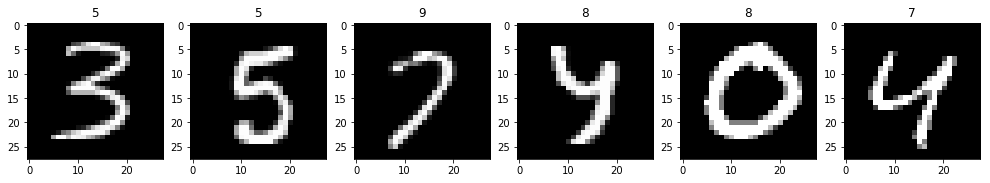

In [40]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

In [41]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

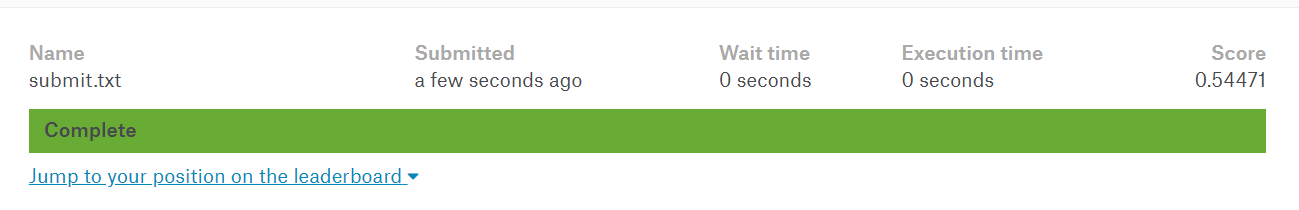
### Your submission scored 0.54

# Часть №2. Теперь будем использовать теперь в качестве признаков результат PCA.

In [42]:
from sklearn.decomposition import PCA

## Мы возьмем также 16 признаков, как и в случае гистограмм, чтобы сравнить.

In [43]:
pca = PCA(n_components=16)
pca.fit(train[:, :784])

PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [44]:
print(sum(pca.explained_variance_ratio_))

0.5953469030489823


In [45]:
X_train = pca.transform(train[:, :784])

In [46]:
X_test = pca.transform(test)

In [47]:
y_train, y_val, x_train, x_val = train_test_split(
    train_label, X_train, test_size=0.2,
    random_state=42)

# 1. KNN классификатор.

In [48]:
params = {
    'n_neighbors':np.arange(1, 10)
}

gsearch = GridSearchCV(KNeighborsClassifier(), params, n_jobs=-1)
gsearch.fit(x_train, y_train)
n_neighbors_best = gsearch.best_params_['n_neighbors']

In [49]:
clf = KNeighborsClassifier(n_neighbors=n_neighbors_best)
clf.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [50]:
y_val_predict = clf.predict(x_val)

In [51]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, y_val_predict))

Accuracy: 0.958452380952381


In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_predict))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       816
         1.0       0.97      0.99      0.98       909
         2.0       0.97      0.96      0.96       846
         3.0       0.96      0.93      0.94       937
         4.0       0.98      0.95      0.96       839
         5.0       0.95      0.95      0.95       702
         6.0       0.96      0.99      0.97       785
         7.0       0.96      0.95      0.96       893
         8.0       0.96      0.95      0.95       835
         9.0       0.91      0.93      0.92       838

   micro avg       0.96      0.96      0.96      8400
   macro avg       0.96      0.96      0.96      8400
weighted avg       0.96      0.96      0.96      8400



In [53]:
pred_test = clf.predict(X_test).astype(int)

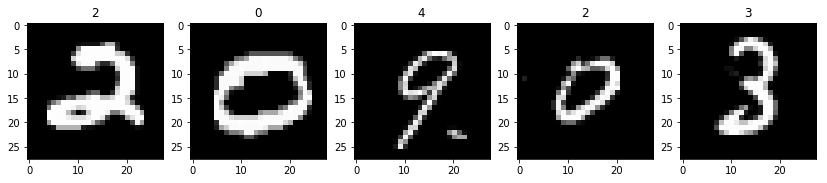

In [54]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

In [55]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

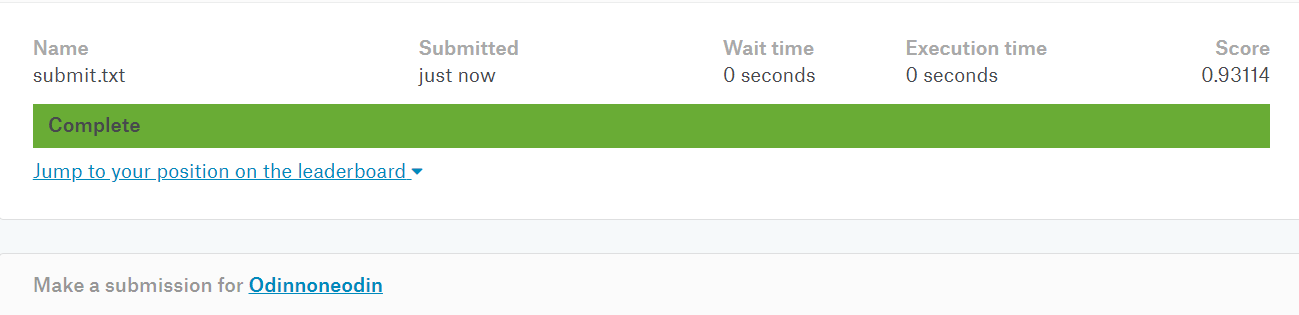

### Your submission scored 0.93

# 2. XGB классификатор.

In [56]:
params = {
    'learning_rate':np.linspace(0.1, 0.9, 9),
    'max_depth':np.arange(1, 5)
}

gsearch = GridSearchCV(XGBClassifier(), params, n_jobs=-1)
gsearch.fit(x_train, y_train)
learning_rate_best = gsearch.best_params_['learning_rate']
max_depth_best = gsearch.best_params_['max_depth']

In [70]:
clf = XGBClassifier(
    max_depth=max_depth_best,
    learning_rate=learning_rate_best
)
clf.fit(x_train, y_train)
y_val_predict = clf.predict(x_val)

In [71]:
print('Accuracy: %s' % accuracy_score(y_val, y_val_predict))

Accuracy: 0.9466666666666667


In [72]:
print(classification_report(y_val, y_val_predict))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       816
         1.0       0.99      0.99      0.99       909
         2.0       0.95      0.94      0.94       846
         3.0       0.94      0.91      0.93       937
         4.0       0.96      0.93      0.95       839
         5.0       0.92      0.93      0.93       702
         6.0       0.96      0.98      0.97       785
         7.0       0.95      0.94      0.95       893
         8.0       0.92      0.95      0.93       835
         9.0       0.90      0.92      0.91       838

   micro avg       0.95      0.95      0.95      8400
   macro avg       0.95      0.95      0.95      8400
weighted avg       0.95      0.95      0.95      8400



In [73]:
pred_test = clf.predict(X_test).astype(int)

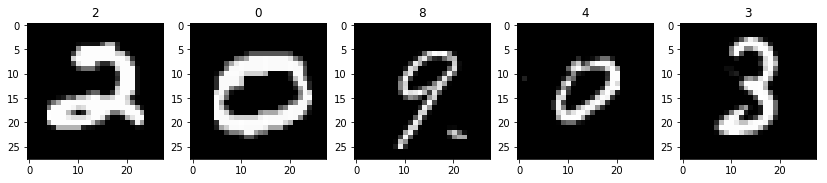

In [74]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

In [75]:
with open('submit1.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

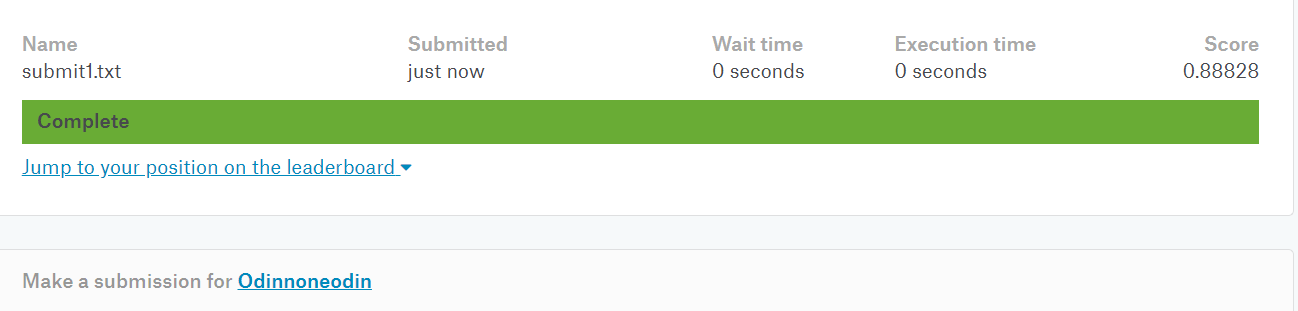

### Your submission scored 0.89

# Таким образом мы получили наилучший результат с использованием PCA и модели KNN.